In [1]:
import wandb
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
fontsize=15
titlesize=20
imgsize=7
linewidth=3
markersize=10

In [3]:
# Sweeps

# batch: wandb agent badboyz2000/normal_mixture/oc4zldcd
# batch+a: wandb agent badboyz2000/normal_mixture/t66w5vo4

# neg: wandb agent badboyz2000/normal_mixture/jnh55spw
# neg+a: wandb agent badboyz2000/normal_mixture/oto3pqm2


In [4]:
api = wandb.Api()

# Batch Size

In [16]:
runs = list(api.sweep('badboyz2000/normal_mixture/oc4zldcd').runs)
runs += list(api.sweep('badboyz2000/normal_mixture/t66w5vo4').runs)

results = []

config_keys = {
    "fit.model.init_args.mi_estimator.init_args.discriminative_estimator.class_path" : "Discriminative model",
    "fit.model.init_args.mi_estimator.init_args.generative_estimator.class_path": "Generative model",
    "fit.model.init_args.mi_estimator.init_args.discriminative_estimator.init_args.neg_samples": "Negative samples",
    "fit.data.init_args.batch_size": "Batch size"
}

results_keys = {
    "mi/value/train_epoch": "mi",
    "mi/value/variance/train_epoch" : "Variance",
    "mi/gen/value/train_epoch": "generative mi",
    "mi/dis/value/train_epoch": "discriminative mi",
    "_runtime": "runtime"
}


for run in tqdm(runs):
    if run.state == "finished" and run.summary["trainer/global_step"]>90000:
        entry = {}
        for key, name in config_keys.items():
            if key in run.config:
                entry[name] = run.config[key]
            else:
                entry[name] = "None"
        for key, name in results_keys.items():
            entry[name] = float(run.summary[key])
        entry["name"] = run.name

        results.append(entry)
    else:
        print(run, run.state)

results = pd.DataFrame(results)

  0%|          | 0/156 [00:00<?, ?it/s]

<Run badboyz2000/normal_mixture/f9q31lxt (running)> running


In [17]:
results['Discriminative model'].unique()

array(['core.models.mi_estimator.FLO',
       'core.models.mi_estimator.AlphaTUBA',
       'core.models.mi_estimator.InfoNCE',
       'core.models.mi_estimator.SMILE', 'core.models.mi_estimator.MINE',
       'core.models.mi_estimator.JS', 'core.models.mi_estimator.NWJ'],
      dtype=object)

In [18]:
true_mi = 6.8526
results["Bias"] = np.abs(results["mi"]-true_mi)
results["Generative model"] = [r.split('.')[-1] for r in results["Generative model"]]
results["Discriminative model"] = [r.split('.')[-1] for r in results["Discriminative model"]]
results

,Discriminative model,Generative model,Negative samples,Batch size,mi,Variance,generative mi,discriminative mi,runtime,name,Bias
0,FLO,None,1,512,4.677692,0.792596,0.000000,4.677692,1525.868774,charmed-sweep-93,2.174908
1,FLO,BA,1,512,6.438766,0.030565,4.638659,1.800108,1737.945128,cosmic-sweep-92,0.413834
2,AlphaTUBA,None,0,512,4.551282,0.001719,0.000000,4.551282,2927.266043,deft-sweep-91,2.301318
3,AlphaTUBA,BA,0,512,5.597084,0.005171,4.641183,0.955900,2832.862390,worthy-sweep-90,1.255516
4,InfoNCE,None,0,512,3.200249,0.000786,0.000000,3.200249,2385.671831,generous-sweep-89,3.652351
...,...,...,...,...,...,...,...,...,...,...,...
150,AlphaTUBA,ABC,0,8,4.199264,0.067280,3.466684,0.732595,2360.210202,usual-sweep-6,2.653336
151,InfoNCE,ABC,0,8,4.126903,0.064930,3.466603,0.660312,1920.064628,easy-sweep-5,2.725697
152,SMILE,ABC,1,8,7.630090,3.744472,3.466778,4.163325,1873.436837,vivid-sweep-4,0.777490
153,MINE,ABC,1,8,6.903141,3.754904,3.466778,3.436355,1920.303293,glowing-sweep-3,0.050541


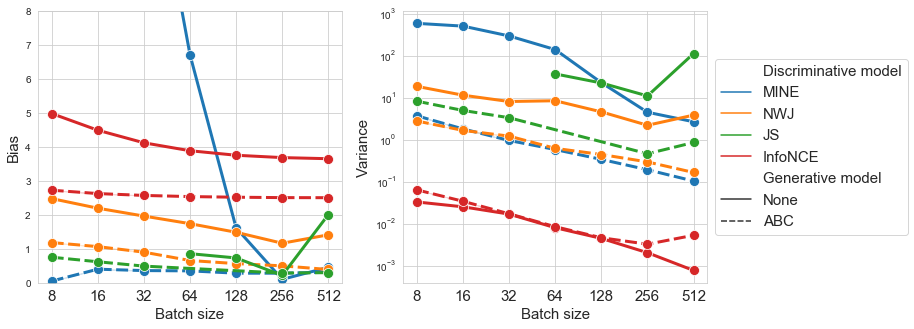

In [19]:
f, ax = plt.subplots(1,2, figsize=(12,5))

disc_models_to_show = ["MINE", "NWJ", "JS", "InfoNCE"]#, "SMILE", "AlphaTUBA", "FLO"] #, "JS", "SMILE", "FLO"], #AlphaTUBA
gen_models_to_show=["None",  "ABC"]
sns.lineplot(results,
             x="Batch size", y="Bias", hue="Discriminative model", style="Generative model",
             hue_order=disc_models_to_show,
             style_order=gen_models_to_show,
             linewidth=linewidth,
             marker='o',
             markersize=markersize,
             ax=ax[0], legend=False)

sns.lineplot(results,
             x="Batch size", y="Variance", hue="Discriminative model", style="Generative model",
             hue_order=disc_models_to_show,
             style_order=gen_models_to_show,
             linewidth=linewidth,
             marker='o',
             markersize=markersize,
             ax=ax[1])


ax[0].set_ylim(0,8)
ax[1].set_yscale("log")

for i in range(2):
    ax[i].set_xscale("log")
    ax[i].set_xticks(2**np.arange(3,10))
    ax[i].set_xticklabels(2**np.arange(3,10), fontsize=fontsize)
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=fontsize)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize)


ax[1].legend(fontsize=fontsize, loc='center left', bbox_to_anchor=(1, 0.5))


# Negative Samples

In [10]:
# neg: wandb agent badboyz2000/normal_mixture/jnh55spw
# neg+a: wandb agent badboyz2000/normal_mixture/oto3pqm2

runs = list(api.sweep('badboyz2000/normal_mixture/jnh55spw').runs)
runs += list(api.sweep('badboyz2000/normal_mixture/oto3pqm2').runs)

results = []

config_keys = {
    "fit.model.init_args.mi_estimator.init_args.discriminative_estimator.class_path" : "Discriminative model",
    "fit.model.init_args.mi_estimator.init_args.generative_estimator.class_path": "Generative model",
    "fit.model.init_args.mi_estimator.init_args.discriminative_estimator.init_args.neg_samples": "Negative samples",
    "fit.data.init_args.batch_size": "Batch size"
}

results_keys = {
    "mi/value/train_epoch": "mi",
    "mi/value/variance/train_epoch" : "Variance",
    "mi/gen/value/train_epoch": "generative mi",
    "mi/dis/value/train_epoch": "discriminative mi",
    "_runtime": "runtime"
}

generative_name = 'model.mi_estimator.predictor'
proposal_key = 'model.mi_estimator.proposal'
result_key = 'mi/value/train_epoch'
result_1_key = 'I_pr(x;y)/train/value_epoch'
result_2_key = 'KL_f(p||r)/train/value_epoch'
var_key = 'I(x;y)/train/value_variance'

for run in tqdm(runs):
    if run.state == "finished" and run.summary["trainer/global_step"]>90000:
        try:
            entry = {}
            for key, name in config_keys.items():
                if key in run.config:
                    entry[name] = run.config[key]
                else:
                    entry[name] = "None"
            for key, name in results_keys.items():
                entry[name] = run.summary[key]
            entry["name"] = run.name
            results.append(entry)
        except:
            print("error", run.name)
    else:
        print(run, run.state)

results = pd.DataFrame(results)

  0%|          | 0/151 [00:00<?, ?it/s]

<Run badboyz2000/normal_mixture/n74urmek (running)> running
<Run badboyz2000/normal_mixture/6x3o8496 (running)> running


In [11]:
true_mi = 6.8526
results["Bias"] = np.abs(results["mi"]-true_mi)
results["Generative model"] = [r.split('.')[-1] for r in results["Generative model"]]
results["Discriminative model"] = [r.split('.')[-1] for r in results["Discriminative model"]]
results

,Discriminative model,Generative model,Negative samples,Batch size,mi,Variance,generative mi,discriminative mi,runtime,name,Bias
0,JS,None,1,64,5.994974,37.251925,0.000000,5.994974,1472.863440,pretty-sweep-72,0.857626
1,JS,BA,1,64,6.583483,0.558622,4.583214,2.000273,2014.036911,atomic-sweep-71,0.269117
2,NWJ,None,63,64,6.218614,0.477159,0.000000,6.218614,1496.754023,elated-sweep-70,0.633986
3,NWJ,BA,63,64,6.689932,0.057917,4.583214,2.106719,2033.283772,stellar-sweep-69,0.162668
4,NWJ,None,32,64,6.060426,0.709283,0.000000,6.060426,1484.238358,stoic-sweep-68,0.792174
...,...,...,...,...,...,...,...,...,...,...,...
144,NWJ,ABC,16,64,6.437464,0.222245,3.466302,2.971159,1978.721413,sweepy-sweep-5,0.415136
145,NWJ,ABC,8,64,6.385102,0.195862,3.466302,2.918803,1960.935559,leafy-sweep-4,0.467498
146,NWJ,ABC,4,64,6.257715,0.433208,3.466302,2.791412,1959.298618,smooth-sweep-3,0.594885
147,NWJ,ABC,2,64,6.278274,0.419049,3.466302,2.811970,1977.995924,eager-sweep-2,0.574326


In [12]:
f  = results[results["Discriminative model"]=="FLO"]
f[f["Generative model"]=="ABC"]

,Discriminative model,Generative model,Negative samples,Batch size,mi,Variance,generative mi,discriminative mi,runtime,name,Bias
87,FLO,ABC,63,64,5.735485,0.053280,3.465283,2.270200,1066.000147,peachy-sweep-62,1.117115
88,FLO,ABC,32,64,5.804823,0.069744,3.465283,2.339544,2147.184734,exalted-sweep-61,1.047777
89,FLO,ABC,16,64,5.809734,0.083360,3.465283,2.344452,1069.010758,hardy-sweep-60,1.042866
90,FLO,ABC,8,64,4.456527,0.972920,3.465283,0.991246,1097.834287,charmed-sweep-59,2.396073
91,FLO,ABC,4,64,5.645646,0.148323,3.465283,2.180364,2184.581305,confused-sweep-58,1.206954
92,FLO,ABC,2,64,5.359904,0.115373,3.465283,1.894622,1122.924588,worthy-sweep-57,1.492696
93,FLO,ABC,1,64,-5.319973,19290.412235,3.465283,-8.785262,1130.011410,hardy-sweep-56,12.172573
121,FLO,ABC,63,64,5.735485,0.053280,3.465283,2.270200,1205.882053,treasured-sweep-35,1.117115
122,FLO,ABC,32,64,5.804823,0.069744,3.465283,2.339544,2311.971609,wild-sweep-34,1.047777
123,FLO,ABC,16,64,5.809734,0.083360,3.465283,2.344452,1167.388147,driven-sweep-33,1.042866


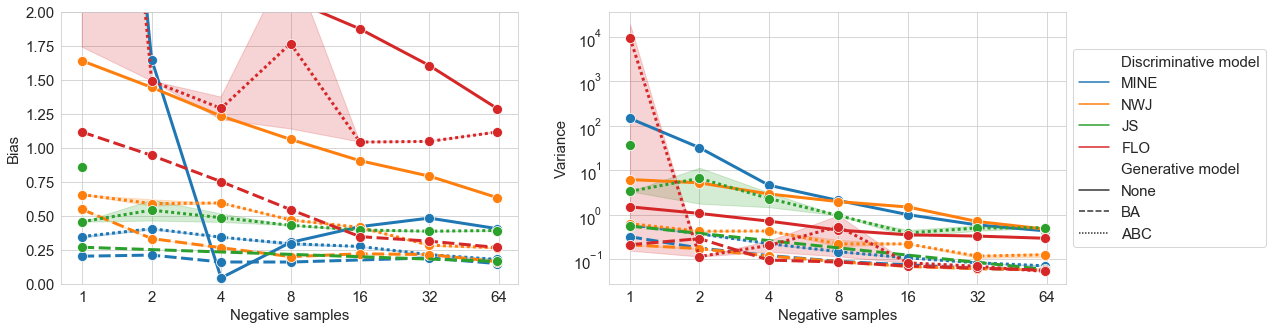

In [13]:
f, ax = plt.subplots(1,2, figsize=(18,5))

disc_models_to_show = ["MINE", "NWJ", "JS", "FLO"] #, "JS", "SMILE", "FLO"], #AlphaTUBA
gen_models_to_show=["None", "BA", "ABC"]
sns.lineplot(results,
             x="Negative samples", y="Bias", hue="Discriminative model", style="Generative model",
             hue_order=disc_models_to_show,
             style_order=gen_models_to_show,
             linewidth=linewidth,
             marker='o',
             markersize=markersize,
             ax=ax[0], legend=False)

sns.lineplot(results,
             x="Negative samples", y="Variance", hue="Discriminative model", style="Generative model",
             hue_order=disc_models_to_show,
             style_order=gen_models_to_show,
             linewidth=linewidth,
             marker='o',
             markersize=markersize,
             ax=ax[1])


ax[0].set_ylim(0,2.)
ax[1].set_yscale("log")

for i in range(2):
    ax[i].set_xscale("log")
    ax[i].set_xticks(2**np.arange(0,7))
    ax[i].set_xticklabels(2**np.arange(0,7), fontsize=fontsize)
    # ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=fontsize)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize)


ax[1].legend(fontsize=fontsize, loc='center left', bbox_to_anchor=(1, 0.5))

# Absolute Comparison

In [14]:
runs = list(api.sweep('badboyz2000/normal_mixture/oc4zldcd').runs)
runs += list(api.sweep('badboyz2000/normal_mixture/t66w5vo4').runs)

results = []

config_keys = {
    "fit.model.init_args.mi_estimator.init_args.discriminative_estimator.class_path" : "Discriminative model",
    "fit.model.init_args.mi_estimator.init_args.generative_estimator.class_path": "Generative model",
    "fit.model.init_args.mi_estimator.init_args.discriminative_estimator.init_args.neg_samples": "Negative samples",
    "fit.data.init_args.batch_size": "Batch size"
}

results_keys = {
    "mi/value/train_epoch": "mi",
    "mi/value/variance/train_epoch" : "Variance",
    "mi/gen/value/variance/train_epoch" : "Generative Variance",
    "mi/gen/value/train_epoch": "generative mi",
    "mi/dis/value/train_epoch": "discriminative mi",
    "_runtime": "Runtime"
}

generative_name = 'model.mi_estimator.predictor'
proposal_key = 'model.mi_estimator.proposal'
result_key = 'mi/value/train_epoch'
result_1_key = 'I_pr(x;y)/train/value_epoch'
result_2_key = 'KL_f(p||r)/train/value_epoch'
var_key = 'I(x;y)/train/value_variance'

for run in tqdm(runs):
    if run.state == "finished":
        entry = {}
        for key, name in config_keys.items():
            if key in run.config:
                entry[name] = run.config[key]
            else:
                entry[name] = "None"
        for key, name in results_keys.items():
            entry[name] = float(run.summary[key])

        results.append(entry)
    else:
        print(run, run.state)

results = pd.DataFrame(results)

true_mi = 6.8526
results["Bias"] = np.abs(results["mi"]-true_mi)
results["Generative model"] = [r.split('.')[-1] for r in results["Generative model"]]
results["Discriminative model"] = [r.split('.')[-1] for r in results["Discriminative model"]]
results

  0%|          | 0/156 [00:00<?, ?it/s]

<Run badboyz2000/normal_mixture/f9q31lxt (running)> running


,Discriminative model,Generative model,Negative samples,Batch size,mi,Variance,Generative Variance,generative mi,discriminative mi,Runtime,Bias
0,FLO,None,1,512,4.677692,0.792596,0.000000,0.000000,4.677692,1525.868774,2.174908
1,FLO,BA,1,512,6.438766,0.030565,0.005608,4.638659,1.800108,1737.945128,0.413834
2,AlphaTUBA,None,0,512,4.551282,0.001719,0.000000,0.000000,4.551282,2927.266043,2.301318
3,AlphaTUBA,BA,0,512,5.597084,0.005171,0.004284,4.641183,0.955900,2832.862390,1.255516
4,InfoNCE,None,0,512,3.200249,0.000786,0.000000,0.000000,3.200249,2385.671831,3.652351
...,...,...,...,...,...,...,...,...,...,...,...
150,AlphaTUBA,ABC,0,8,4.199264,0.067280,0.000625,3.466684,0.732595,2360.210202,2.653336
151,InfoNCE,ABC,0,8,4.126903,0.064930,0.000868,3.466603,0.660312,1920.064628,2.725697
152,SMILE,ABC,1,8,7.630090,3.744472,0.000568,3.466778,4.163325,1873.436837,0.777490
153,MINE,ABC,1,8,6.903141,3.754904,0.000568,3.466778,3.436355,1920.303293,0.050541


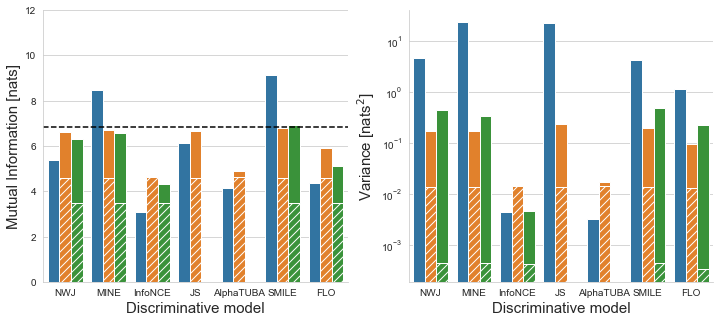

In [15]:
f, ax = plt.subplots(1,2, figsize=(12,5))

batch_size=128

disc_models_to_show = ["NWJ", "MINE", "InfoNCE", "JS", "AlphaTUBA", "SMILE", "FLO"] #
hue_order = ["None", "BA", "ABC"]

g_0 = sns.barplot(
    results[results['Batch size']==batch_size],
    x="Discriminative model",
    order=disc_models_to_show,
    hue="Generative model",
    hue_order=hue_order,
    y="mi",
    ax=ax[0]
)

g = sns.barplot(
    results[results['Batch size']==batch_size],
    order=disc_models_to_show,
    x="Discriminative model",
    hue="Generative model",
    hue_order=hue_order,
    y="generative mi",
    hatch='///',
    ax=ax[0]
)

g.legend_.remove()


g_0 = sns.barplot(
    results[results['Batch size']==batch_size],
    x="Discriminative model",
    order=disc_models_to_show,
    hue="Generative model",
    hue_order=hue_order,
    y="Variance",
    ax=ax[i]
)

g = sns.barplot(
    results[results['Batch size']==batch_size],
    x="Discriminative model",
    y="Generative Variance",
    order=disc_models_to_show,
    hue="Generative model",
    hue_order=hue_order,
    hatch='///',
    ax=ax[i],
)

ax[1].set_yscale("log")
g.legend_.remove()

# g_0.legend_.draw()

# leg = ax.legend(fontsize=fontsize, loc='center left', bbox_to_anchor=(1, 0.5), title="Generative Model")


ax[0].set_ylim(0,12)
ax[0].set_ylabel("Mutual Information [nats]", fontsize=fontsize)
ax[1].set_ylabel("Variance [nats$^2$]", fontsize=fontsize)

for i in range(2):
    ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=fontsize)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize)

ax[0].axhline(y=true_mi, color='k', ls='--')#, label="$I({\\bf x};{\\bf y})$")


sns.despine()

In [15]:
# f, ax = plt.subplots(1,1, figsize=(6,5))
# ax = [ax]
#
# batch_size=64
#
# disc_models_to_show = ["NWJ", "MINE", "InfoNCE", "JS", "AlphaTUBA", "SMILE", "FLO"] #
# hue_order = ["None", "BA", "ABC"]
#
# g_0 = sns.barplot(
#     results[results['Batch size']==batch_size],
#     x="Discriminative model",
#     order=disc_models_to_show,
#     hue="Generative model",
#     hue_order=hue_order,
#     y="Runtime",
#     ax=ax[0]
# )
#
#
# ax[0].set_ylabel("Mutual Information [nats]", fontsize=fontsize)
# ax[1].set_ylabel("Variance [nats$^2$]", fontsize=fontsize)
#
# for i in range(2):
#     ax[i].set_xlabel(ax[i].get_xlabel(), fontsize=fontsize)
#     ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize)
#
# ax[0].axhline(y=true_mi, color='k', ls='--')#, label="$I({\\bf x};{\\bf y})$")
#
#
# sns.despine()

In [16]:
disc_models_to_show

['NWJ', 'MINE', 'InfoNCE', 'JS', 'AlphaTUBA', 'SMILE', 'FLO']